# ODMR measurment script (Run everything until section 3 immediately to check for a stable signal)
## 1. Importing packages
### 1.1 Python, Run untill 1.4 to initialize

In [14]:
from __future__ import print_function
import psutil
from IPython.display import display, clear_output
%matplotlib inline
from scipy.signal import find_peaks
import numpy as np
import matplotlib.pyplot as plt
import zhinst.utils
#import Pyro5.api
import TimeTagger as TT
# convenience import for all LabOne Q software functionality
from laboneq.simple import *
from laboneq.controller.util import *
from time import sleep
import TimeTagger
from scipy.optimize import curve_fit
import time
from datetime import date
import scipy as scipy
from scipy import optimize
import os
from pipython import GCSDevice, pitools
logging.disable(logging.DEBUG)

## Creating a connection with the AWG
### 1.2 Installing LabOneQ package

In [9]:
use_emulation=False
# install token if needed
if not use_emulation:
    install_token("LabOneQ.AllQuantumInOne.")

/home/dl-lab-pc3/.local/lib/python3.10/site-packages/laboneq/_token.py:20: FutureWarning: An access token is no longer required for LabOne Q.
  warnings.warn("An access token is no longer required for LabOne Q.", FutureWarning)


### 1.3 Connecting with the AWG

In [4]:
# Define the DeviceSetup from descriptor - 
# Additionally include information on the dataserver used to connect to the instruments 
server_host = "localhost" # <-- INSERT YOUR SERVER HOST HERE

descriptor = """
instruments:
  SHFSG:
  - address: DEV12120
    uid: device_shfsg
    interface: usb
    
connections:     
  device_shfsg:
    - iq_signal: q0/drive_line
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q0/drive_line_ef
      ports: SGCHANNELS/0/OUTPUT
    - iq_signal: q1/drive_line
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q1/drive_line_ef
      ports: SGCHANNELS/1/OUTPUT
    - iq_signal: q2/drive_line
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: q2/drive_line_ef
      ports: SGCHANNELS/2/OUTPUT
    - iq_signal: q3/drive_line
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: q3/drive_line_ef
      ports: SGCHANNELS/3/OUTPUT
    - iq_signal: q4/drive_line
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: q4/drive_line_ef
      ports: SGCHANNELS/4/OUTPUT
    - iq_signal: q5/drive_line
      ports: SGCHANNELS/5/OUTPUT
    - iq_signal: q5/drive_line_ef
      ports: SGCHANNELS/5/OUTPUT
"""

my_setup = DeviceSetup.from_descriptor(
    yaml_text=descriptor,
    server_host="localhost",
    server_port='8004',
    setup_name='Setup_Name',
)

In [10]:
# Create a TimeTagger instance to control your hardware
tagger = TimeTagger.createTimeTagger()

countrate = TimeTagger.Countrate(tagger=tagger, channels=[1])   # 1 is 1 

ERR: Failed to claim USB interface: Device or resource busy (error 16)


RuntimeError: No Time Tagger attached or already in use. Got the USB error 'Failed' in 'OpenBySerial' in line 176.

### 1.4 Check values of the SPCM

In [5]:
for i in range(10):
    countrate = TimeTagger.Countrate(tagger=tagger, channels=[1]) ###### +1 is rising -1 is falling or under trigger level
    sleep(1)
    print("(1) Init, sleep(0.5s)   | {:>16,d} | {:>20,d}".format(
        countrate.getCountsTotal()[0], countrate.getCaptureDuration()))



NameError: name 'tagger' is not defined

## 2. Setting AWG 
### 2.1 Defining initial values for AWG
## Run this kernel when the AWG had been off!!


In [ ]:
# define baseline signal calibration for a list of qubits
def define_calibration():
    
    calib = Calibration()
    
    calib[f"/logical_signal_groups/q1/drive_line"] = \
        SignalCalibration(
            oscillator = Oscillator(
                frequency =7e7,
                modulation_type=ModulationType.HARDWARE,
            ),
            local_oscillator = Oscillator(
                frequency=2.8e9,                             #center frequency Hz
            ),
            range = 0,                                      #Strength in dBm
        )     
    
    return calib
define_calibration()
my_setup.set_calibration(define_calibration())
my_session = Session(device_setup=my_setup)
my_session.connect(do_emulation=use_emulation)

channel_index = 1          #which channel am I using   #1 is 2
output_range= 0            #leave at 0 = limit of small amp, large amp has 7 dbm but check for large amp to make sure
center_frequency = 2.8e9
rflf_path= 1
osc1_frequency= 7e7

# Configurational
instrument_serial = my_setup.instruments[0].address
device = my_session.devices[instrument_serial]

gains_cw              = (0.0, 0.95, 0.95, 0.0) #unitless

# Configure RF output
device.sgchannels[channel_index].configure_channel(enable = True, output_range = output_range, 
                                                   center_frequency = center_frequency, rf_path = rflf_path)



# Configure digital sine generator
device.sgchannels[channel_index].configure_sine_generation(enable = True, 
                                                           osc_index = 0, osc_frequency = osc1_frequency, 
                                                           phase = 0, gains = gains_cw)



### 2.2 Starting retrieving data from counter and measuring average dip


In [18]:
move_x(0,1.018)


# #Variable (this determines how long you want to measure the current PL output)
# N = 100

# # Standard functions
# TimeStart = time.time()
# x = []
# y = []
# ct = time.strftime("%H:%M:%S")

# # Interactive plot
# plt.rcParams['figure.figsize'] = [12, 4]
# fig = plt.figure()
# ax = fig.add_subplot(111)

# # showing the stability of the current signal (we use 1e11 here to reduce the time it takes)
# for n in range(N):
#     ax.clear()
#     countrate.startFor(2e11)
#     countrate.waitUntilFinished()
#     rate = countrate.getData()
#     x.append(time.time()-TimeStart)
#     y.append(rate)
#     ax.plot(x,y, ls = ":", marker = ".")
#     ax.set_title("ODMR Signal Stability at {}" .format(ct))
#     ax.set_ylabel("Counts/s")
#     ax.set_xlabel("Time (s)")
#     display(fig)
#     clear_output(wait=True)
    
# ymax = max(y)
# ymin = min(y)
# difference = ymax-ymin
# #fluct = np.mean(y)
# print("The fluctuation is a maximum of {}% currently" .format(difference/ymax*100))

GCSError: There is no interface or DLL handle with the given ID (-9)

## 2.3 Setting the PI MikroMove functions (Filip + Alfie)

In [17]:
CONTROLLERNAME = 'E-873'  # 'C-884' will also work
#STAGES = ['Q-545.140']
#REFMODES = ['FNL', 'FRF']

def move_x(mini,maxi):
    '''
        moves the object to specified coordinate.
    args:
    mini : Starting coordinate
    maxi : Final coordinate
    Errors:
    mini has to be different than maxi.
    '''
    with GCSDevice(CONTROLLERNAME) as pidevice:
        pidevice.ConnectUSB(serialnum='122053192')
        # pidevice.ConnectUSB(serialnum='122053190')
        # pidevice.ConnectUSB(serialnum='122058829')

#         print('connected: {}'.format(pidevice.qIDN().strip()))

        # Show the version info which is helpful for PI support when there
        # are any issues.

#         if pidevice.HasqVER():
#             print('version info:\n{}'.format(pidevice.qVER().strip()))

        rangemin = mini
        rangemax = maxi

        for axis in pidevice.axes:
            for target in (rangemin, rangemax):
                # print('move axis {} to {:.2f}'.format(axis, target))
                pidevice.MOV(axis, target)

                # To check the "on target state" of an axis there is the GCS command
                # qONT(). But it is more convenient to just call "waitontarget".

                pitools.waitontarget(pidevice, axes=axis)

                #position = pidevice.qPOS(axis)[axis]  # query single axis
                # position = pidevice.qPOS()[str(axis)] # query all axes
                # print('current position of axis {} is {:.2f}'.format(axis, position))
                #time.sleep(0.01)
        
def move_y(mini,maxi):
    '''
        moves the object to specified coordinate.
    args:
    mini : Starting coordinate
    maxi : Final coordinate
    Errors:
    mini has to be different than maxi.
    '''
    with GCSDevice(CONTROLLERNAME) as pidevice:
        # pidevice.ConnectUSB(serialnum='122053192')
        pidevice.ConnectUSB(serialnum='122053190')
        # pidevice.ConnectUSB(serialnum='122058829')

#         print('connected: {}'.format(pidevice.qIDN().strip()))

        # Show the version info which is helpful for PI support when there
        # are any issues.

#         if pidevice.HasqVER():
#             print('version info:\n{}'.format(pidevice.qVER().strip()))

        rangemin = mini
        rangemax = maxi

        for axis in pidevice.axes:
            for target in (rangemin, rangemax):
                # print('move axis {} to {:.2f}'.format(axis, target))
                pidevice.MOV(axis, target)

                # To check the "on target state" of an axis there is the GCS command
                # qONT(). But it is more convenient to just call "waitontarget".

                pitools.waitontarget(pidevice, axes=axis)

                #position = pidevice.qPOS(axis)[axis]  # query single axis
                # position = pidevice.qPOS()[str(axis)] # query all axes
                # print('current position of axis {} is {:.2f}'.format(axis, position))
                #time.sleep(0.01)
                
def move_z(mini,maxi):
    '''
    moves the object to specified coordinate.
    args:
    mini : Starting coordinate
    maxi : Final coordinate
    Errors:
    mini has to be different than maxi.
    
    '''
    with GCSDevice(CONTROLLERNAME) as pidevice:
        # pidevice.ConnectUSB(serialnum='122053192')
        # pidevice.ConnectUSB(serialnum='122053190')
        pidevice.ConnectUSB(serialnum='122058829')

#         print('connected: {}'.format(pidevice.qIDN().strip()))

        # Show the version info which is helpful for PI support when there
        # are any issues.

#         if pidevice.HasqVER():
#             print('version info:\n{}'.format(pidevice.qVER().strip()))

        rangemin = mini
        rangemax = maxi

        for axis in pidevice.axes:
            for target in (rangemin, rangemax):
                # print('move axis {} to {:.2f}'.format(axis, target))
                pidevice.MOV(axis, target)

                # To check the "on target state" of an axis there is the GCS command
                # qONT(). But it is more convenient to just call "waitontarget".

                pitools.waitontarget(pidevice, axes=axis)

                #position = pidevice.qPOS(axis)[axis]  # query single axis
                # position = pidevice.qPOS()[str(axis)] # query all axes
                # print('current position of axis {} is {:.2f}'.format(axis, position))
                #time.sleep(0.01)

In [16]:
move_x(0,1)

GCSError: There is no interface or DLL handle with the given ID (-9)

# 3 ODMR Code

## 3.1 Finding appropriate limits

In [ ]:
# Variables to check the peak locations
N = 100
ifr = -0.00e9
ffr = 0.14e9

# Standard arrays
freq = np.linspace(ifr,ffr,N)
freqrange = freq + center_frequency
    
# Interactive plot to check the peak locations
plt.rcParams['figure.figsize'] = [12, 4]
fig = plt.figure()
ax = fig.add_subplot(111)
x = []
y = []   

for n in range(N):  
    ax.clear()
    osc1_frequency = freq[n]
    # Configure digital sine generator
    device.sgchannels[channel_index].configure_sine_generation(enable = True,
                                                               osc_index = 0,
                                                               osc_frequency = osc1_frequency, 
                                                               phase = 0,
                                                               gains = gains_cw)
    # This loop determines individual values for each measurement loop
    countrate.startFor(4e11)
    countrate.waitUntilFinished()
    rate = countrate.getData()
    x.append(freqrange[n])
    y.append(rate)
    ax.plot(x,y, color='red', markerfacecolor = "red", marker = ".", ls = ":")
    ax.set_title("Intensity Plot")
    ax.set_ylabel("Counts/s")
    ax.set_xlabel("Frequency (Hz)")
    display(fig)
    #time.sleep(0.1)
    clear_output(wait=True)
plt.show()

## 3.2 Frequency Sweep Code (Harsh + Alfie)

In [87]:
# This code uses a nice frequency sweep and averages over multiple measurements

# Initialise the time of the measurement
ti = time.time()
ct = time.localtime()
current_time = time.strftime("%H-%M-%S", ct)

# Center frequency is 2.8 GHz, thus: define the frequency sweep accordingly
# A sweep from 2 GHz -> 3 Ghz is defined as: -0.87e9, 0.13e9
# We need 2.87 as the center frequency. Take this into account with measurements
initialfreq = -0.04e9
finalfreq = 0.2e9 # Always keep final freq +0.14 for a centered graph (around gyroscopic frequency)

# Initialise the full loop:
measurements = 500 # The number of frequencies that will be scanned, this determines the step size of the frequency sweep
loops = 2 #The amount of measurements that will combine into one

# This will be the total data matrix
data = np.zeros((loops,measurements))
freq = np.linspace(initialfreq,finalfreq,measurements)
x = freq + center_frequency

# This line determines the time it will take to perform these measurements (+-)
seconds = (measurements * loops)/(500 * 2) * 139.10563492774963
minutes = np.round(seconds/60, decimals = 1)
print("This frequency sweep will take about {} minute(s). Measurement started at {}" .format(minutes, current_time))

# Full loop
for i in range(loops):
    # The loop here is used to send configure the MW generator
    for n in range(measurements):  
        osc1_frequency = freq[n]
        # Configure digital sine generator
        device.sgchannels[channel_index].configure_sine_generation(enable = True,
                                                                   osc_index = 0,
                                                                   osc_frequency = osc1_frequency, 
                                                                   phase = 0,
                                                                   gains = gains_cw)
        # This loop determines individual values for each measurement loop
        countrate.startFor(4e11)
        countrate.waitUntilFinished()
        rate = countrate.getData()
        data[i][n] = rate
    # Plotting individual values
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.title("PL spectrum of individual measurements")
    plt.plot(x, data[i], ls = ":", label = "Plot #{}" .format(i+1))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Photon counts")
plt.legend()
plt.show() 
    
averagedata = data.mean(0)  
# This shows the time the measurement took
tf = time.time()
timetotal = (tf-ti)/60
print("Frequency sweep completed in {} minute(s)" .format(np.round(timetotal,decimals=1)))

NameError: name 'center_frequency' is not defined

## 3.3 Normalized Combined Plot + Saving Data

In [ ]:
# Normalizing the acquired data
MaximumCounts = max(averagedata)
NormalizedData = averagedata/MaximumCounts
print()
# Obtaining the minimum value to calculate the difference in average photon counts vs PL dip
MinimumCounts = min(averagedata)

# Use these parameters to pick the correct width (min and max) and height of the peak
#width = [1,50]
height = -0.98

# Locating the peaks using scipy.find_peaks:
# peaks, _ = find_peaks(-NormalizedData, height = height)
# print("This measurement located {} ODMR peaks" .format(len(peaks)))
# print("The peak(s) are located at frequencies: {} GHz" .format(x[peaks]/1e9))

# Manual Peaks:
P1 = 2.8221e9
P2 = 2.918e9

# Normalized plot with peak locations:
plt.figure(figsize=(12,8))
#plt.set_xticks(np.arange(start,end,0.5))
plt.axvline(x=P1, color='#32a89e', ls='-.', lw=2, label='f-')
plt.axvline(x=P2, color='#32a89e', ls='-.', lw=2, label='f+')
plt.plot(x, NormalizedData, ls = "none", marker = ".", label = "Normalized Plot")
plt.plot(x, NormalizedData, ls = ":", color = "#8B0000", label = "Normalized plot (connected)")
# plt.plot(x[peaks], NormalizedData[peaks], "xr", label = "Peaks")
plt.hlines(-height, xmin=x[0], xmax=x[-1], colors='grey', ls = "--", label = "Minimum Height to Locate Peaks")
plt.title("Normalized ODMR PL Spectrum, N = {}, average over {} graphs" .format(measurements, loops))
plt.xlim(x[0],x[-1])
plt.xlabel("Frequency (Hz)")
plt.ylabel("Normalized PL")
plt.axvline(x=2.87e9, color='green', ls=':', lw=2, label='Gyroscopic frequency (2.87 GHz)')
plt.grid()
plt.legend()
plt.show()

# Saving the data as a csv file (frequency and photon counts)
#np.savetxt("ODMRData.csv",[x,averagedata],delimiter =", ")
data = np.column_stack([x, averagedata])
todayDate = time.strftime("%d-%m-%y")
directory = todayDate
parent = 'C:\ODMRAlfie/'
if os.path.exists(directory) == True:
    os.mkdir(os.path.join(parent, directory))
filename = "ODMR PL at {}" .format(current_time)
datafile_path = "C:\ODMRAlfie\{}/{}.txt" .format(todayDate,filename)
np.savetxt(datafile_path , data, fmt=['%d','%d'])

print(tf)

In [ ]:
#plt.plot(x,data[0,:])

## Calculating the Magnetic Field

We can use the function: 
$$ \Delta f = f_+ - f_- = 2 \gamma_e \vec{|B_z|} $$

to calculate the magnetic field using the length of the peaks from the center frequency (2.87 GHz).
$\gamma_e$ is the gyromagnetic ratio and equal to: 28.024 GHz/T. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7015934/)

Rewriting yields: 
$$ \dfrac{(f_+ - f_-)}{2\gamma_e} = \vec{|B_z|} $$

In [ ]:
fplus = max(x[peaks])
fminus = min(x[peaks])
gamma_e = 28.024e9

def magneticfieldstrength(fplus,fminus):
    return (fplus-fminus)/(2*gamma_e)

MFS = magneticfieldstrength(fplus,fminus)
MFSmanual = magneticfieldstrength(P2,P1)
Gauss = MFS*10e3
Gaussmanual = np.round(MFSmanual*10e3, decimals = 1)
print("The magnetic field of this measurement was: {} G" .format(Gauss))
print("The magnetic field of this measurement is about: {} G (peaks picked manually)" .format(Gaussmanual))

## Creating 3D plot (Only Run After Acquiring All Data)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16,16),dpi = 300)
# Loading and normalising data
data8 = np.loadtxt("ODMRTIME3D/ODMR PL at 15-26-58.txt")
normalised8 = data8[:,1]/max(data8[:,1])
data7 = np.loadtxt("ODMRTIME3D/ODMR PL at 15-09-59.txt")
normalised7 = data7[:,1]/max(data7[:,1])
data6 = np.loadtxt("ODMRTIME3D/ODMR PL at 14-54-02.txt")
normalised6 = data6[:,1]/max(data6[:,1])
data5 = np.loadtxt("ODMRTIME3D/ODMR PL at 14-29-57.txt")
normalised5 = data5[:,1]/max(data5[:,1])
data4 = np.loadtxt("ODMRTIME3D/ODMR PL at 14-04-48.txt")
normalised4 = data4[:,1]/max(data4[:,1])
data3 = np.loadtxt("ODMRTIME3D/ODMR PL at 13-19-47.txt")
normalised3 = data3[:,1]/max(data3[:,1])
data2 = np.loadtxt("ODMRTIME3D/ODMR PL at 12-25-19.txt")
normalised2 = data2[:,1]/max(data2[:,1])
data1 = np.loadtxt("ODMRTIME3D/ODMR PL at 15-58-14.txt")
normalised1 = data1[:,1]/max(data1[:,1])

B8 = 66.2
B7 = 46.9
B6 = 29.7
B5 = 18.3
B4 = 11.4
B3 = 7.34
B2 = 0.772
B1 = 0

x = data8[:,0]/1e9
N = len(x)
# Plots

ax = fig.add_subplot(111, projection = "3d")
ax.set_box_aspect(aspect = (40,60,18))

ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel("Z axis label" , fontsize=20, rotation=-90)
#ax.view_init(30, 30) 
ax.set(facecolor = "None")
ax.set_zlabel("Normalized PL", fontsize = "20")
ax.set_ylabel("Magnetic Field Strength (Gs)", fontsize = "20")
ax.set_xlabel("Frequency (GHz)", fontsize = "20")
ax.set_title('ODMR of Different Magnetic Fields', fontsize = "40");
#ax.view_init(elev=50, azim=-50)
ax.plot(x,B8*np.ones(N),normalised8, lw = 2, ls= "-", label = "B = {} Gs" .format(B8))
ax.plot(x,B7*np.ones(N),normalised7, lw = 2, ls= "-", label = "B = {} Gs" .format(B7))
ax.plot(x,B6*np.ones(N),normalised6, lw = 2, ls= "-", label = "B = {} Gs" .format(B6))
ax.plot(x,B5*np.ones(N),normalised5, lw = 2, ls= "-", label = "B = {} Gs" .format(B5))
ax.plot(x,B4*np.ones(N),normalised4, lw = 2, ls= "-", label = "B = {} Gs" .format(B4))
ax.plot(x,B3*np.ones(N),normalised3, lw = 2, ls= "-", label = "B = {} Gs" .format(B3))
ax.plot(x,B2*np.ones(N),normalised2, lw = 2, ls= "-", label = "B = {} Gs" .format(B2))
ax.plot(x,B1*np.ones(N),normalised1, lw = 2, ls= "-", label = "B = {} Gs" .format(B1))
#ax.legend(fontsize="7.5", bbox_to_anchor=(1.9, 0.5),ncol=2)
ax.legend(loc='upper left',fontsize = "20")
ax.grid(True)
# Saving the file
plt.tight_layout()
file = "C:/ODMRAlfie/10-10-23/"
plt.savefig(file + "ODMRofMagneticFields.png", dpi = 100, transparent=False)

plt.show()

# 4 Other Measurements

## 4.1 2D Scan of PL

In [3]:
move_z(6.41,6.41)


NameError: name 'GCSDevice' is not defined

In [62]:
# Variables for scan (first 1D)
steps = 200
x_i = -2
x_f = 3
y_i = 0
y_f = 5

# Array:
xmove = np.linspace(x_i,x_f,steps)
ymove = np.linspace(y_i,y_f,steps)
move_z(6.41,6.41)
PL = np.zeros((steps,steps))

# Loop for 2D Scan
for i in range(steps):
    move_y(ymove[i],ymove[i])
    time.sleep(1)
    for j in range(steps):
        move_x(xmove[j],xmove[j])
        countrate.startFor(4e11)
        countrate.waitUntilFinished()
        rate = countrate.getData()
        print("Current PL: {}, on position: x = {}, y = {}"
              .format(rate,np.round(xmove[j],decimals = 2),np.round(ymove[i],decimals = 2)), end='\r')
        PL[i][j] = rate 

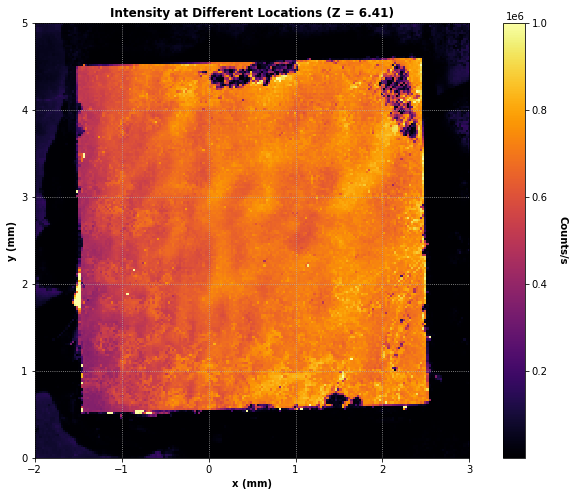

In [85]:
# Saving the data:
np.savetxt('C:/ODMRAlfie/18-10-23/2DScan1.0.0_200.txt', PL)

# Setting the maximum value shown:
vmax = 1e6

# Colour plot of diamond surface
plt.figure(figsize=(12,8))
pos = plt.imshow(PL, cmap='inferno', interpolation = "None", extent = [x_i, x_f, y_i, y_f], vmax = vmax)
plt.title("Intensity at Different Locations (Z = 6.41)", fontweight ="bold")
plt.xlabel("x (mm)", fontweight ="bold")
plt.ylabel("y (mm)", fontweight ="bold")
cb = plt.colorbar(pos)
cb.set_label('Counts/s', rotation=270, fontweight ="bold", labelpad=20)
plt.grid(ls = ":")
file = "C:/ODMRAlfie/18-10-23/"
plt.savefig(file + "2DScan1.0.0_200.png", dpi = 100, transparent=False)
plt.show()

In [ ]:
# 1D Scan
# Plotting the PL vs position (x-axis)
plt.figure(figsize=(12,8))
plt.plot(xmove,PL, ls = "None", marker = ".")
plt.plot(xmove,PL, ls = ":", marker = "None")
plt.title("Intensity for Different Locations (y = 2.218, z = 6.41)")
plt.xlabel("x (mm)")
plt.ylabel("Counts/s")
plt.show()

In [82]:
# Moving the piezo stage (for maintenance or other things)
# move_z(3,3)
# move_y(5,5)
# move_x(0,0)